# Recognize Exercise Type Using Aggregated Statistics from the Signals
- Map all exercise names to exercise type classes so that similar exercises (i.e dumbbell curl left arm and dumbbell curl right arm get grouped)
- Model Neural Network
- Cross-validated test loss: 0.5524, Cross-validated test accuracy: 0.8660

#### import libraries

In [1]:
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
import pandas as pd
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import PCA
from pyspark.sql import SparkSession
from pyspark.sql.functions import col, lag, udf, greatest, least, struct
from pyspark.sql.types import *
import random
import scipy.signal as signal
import scipy.io
import warnings

import torch
import torch.nn as nn
import torch.optim as optim
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder

warnings.filterwarnings('ignore')

## Load data
- Data format: 1 row for each time point
- Map the exercises to classes

In [15]:
df = pd.read_csv("../bigfiles/exercise_recognition_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6134191 entries, 0 to 6134190
Data columns (total 11 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   set_num     int64  
 2   activity    object 
 3   time        float64
 4   x_gyro      float64
 5   y_gyro      float64
 6   z_gyro      float64
 7   x_acc       float64
 8   y_acc       float64
 9   z_acc       float64
 10  label       float64
dtypes: float64(8), int64(2), object(1)
memory usage: 514.8+ MB


In [16]:
# remove infrequent activities
infrequent_activities = ['Box Jump (on bench)',
 'Lawnmower (label spans both arms)',
 'Overhead Triceps Extension (label spans both arms)']

df = df[~df['activity'].isin(infrequent_activities)]

In [97]:
# group columns according to this mapping:
exercise_classes = {
    "Dumbbell Row": [
        "Dumbbell Deadlift Row",
        "Dumbbell Row (knee on bench) (label spans both arms)",
        "Dumbbell Row (knee on bench) (left arm)",
        "Dumbbell Row (knee on bench) (right arm)",
    ],
    "Band Pull-Down Row": [ "Band Pull-Down Row" ],
    "Rowing machine": [ "Rowing machine" ],
    "Lawnmower": [
        "Lawnmower (label spans both arms)",
        "Lawnmower (left arm)",
        "Lawnmower (right arm)",
    ],
    "Back Exercise": [
        "Seated Back Fly"
    ],    
    "Bicep Curl": [
        "Bicep Curl",
        "Biceps Curl (band)",
        "Two-arm Dumbbell Curl (both arms, not alternating)"
    ],
    "Chest Press": [
        "Chest Press (rack)"
    ],
    "Triceps Extension": [
        "Overhead Triceps Extension",
        "Overhead Triceps Extension (label spans both arms)",
        "Triceps extension (lying down)"
    ],
    "Dip": ["Dip"],
    "Tricep Kickback": [
        "Triceps Kickback (knee on bench) (label spans both arms)",
        "Triceps Kickback (knee on bench) (left arm)",
        "Triceps Kickback (knee on bench) (right arm)",
    ],
    "Shoulder Press": [
        "Shoulder Press (dumbbell)",
        "Squat Rack Shoulder Press"
    ],
    "Lateral Raise": [ "Lateral Raise" ],
    "Box Jump" : [ "Box Jump (on bench)" ],
    "Lunge": [ 
        "Lunge (alternating both legs, weight optional)", 
        "Walking lunge"
    ],
    "Squat Variant": [
        "Squat",
        "Squat (arms in front of body, parallel to ground)",
        "Squat (hands behind head)",
        "Squat (kettlebell / goblet)",
        "Squat Jump"
    ],
    "Weighted squat": [
        "Dumbbell Squat (hands at side)",
        "Squat (kettlebell / goblet)"
    ],
    "Wall Squat": [
        "Wall Squat"
    ],
    "Sit Up Variant": [
        "Butterfly Sit-up",
        "Crunch",
        "Sit-up (hands positioned behind head)",
        "Sit-ups",
        "V-up"
    ],
    "Russian Twist": [
        "Russian Twist"
    ],
    "Plank": [
        "Plank",
        "Side Plank Left side",
        "Side Plank Right side",
    ],
    "Stretches": [
        "Dynamic Stretch (at your own pace)",
        "Static Stretch (at your own pace)",
        "Static stretch",
        "Power Boat pose",
        "Repetitive Stretching",
    ],
    "Push up variant": [
        "Burpee",
        "Pushup (knee or foot variation)",
        "Pushups",
    ],
    "Elliptical machine": [
        "Elliptical machine"
    ],
    "Fast Alternating Punches": [
        "Fast Alternating Punches"
    ],
    "Jump Rope": [
        "Jump Rope"
    ],
    "Jumping Jacks": [
        "Jumping Jacks"
    ],
    "Running (treadmill)": [
        "Running (treadmill)"
    ],
    "Walk": [
        "Walk"
    ],
    "Kettlebell Swing": [
        "Kettlebell Swing"
    ],
    "Medicine Ball Slam": [
        "Medicine Ball Slam"
    ],
    "Wall Ball": [
        "Wall Ball"
    ]
}

df['exercise_class'] = df['activity'].apply(lambda x: [k for k, v in exercise_classes.items() if x in v][0] 
                                                       if any(x in v for v in exercise_classes.values()) 
                                                       else 'Unknown')


In [98]:
df[df.exercise_class == 'Unknown'].activity.unique()

array([], dtype=object)

## Feature Computation
Get interquartile range, variance, skewness, kurtosis, root mean square error of the signal amplitude
aggregated for each set

In [99]:
df_byset = df.groupby(["exercise_class","activity","set_num"])
signal_cols = [col for col in df.columns 
               if col.startswith("x") or col.startswith("y") or col.startswith("z")]


In [100]:
df_means = df_byset[signal_cols].mean().add_suffix('_mean')
df_iqr = df_byset[signal_cols].quantile(0.75) - df_byset[signal_cols].quantile(0.25)
df_iqr = df_iqr.add_suffix('_iqr')
df_var = df_byset[signal_cols].var().add_suffix('_var')
df_skew = df_byset[signal_cols].skew().add_suffix('_skew')
df_kurt = df_byset[signal_cols].apply(pd.DataFrame.kurt).add_suffix('_kurt')
df_rms = df_byset[signal_cols].apply(lambda x: np.sqrt(np.mean(x**2))).add_suffix('_rms')

joined = df_means.join(df_iqr).join(df_var).join(df_skew).join(df_kurt).join(df_rms)

In [101]:
joined.columns

Index(['x_gyro_mean', 'y_gyro_mean', 'z_gyro_mean', 'x_acc_mean', 'y_acc_mean',
       'z_acc_mean', 'x_gyro_iqr', 'y_gyro_iqr', 'z_gyro_iqr', 'x_acc_iqr',
       'y_acc_iqr', 'z_acc_iqr', 'x_gyro_var', 'y_gyro_var', 'z_gyro_var',
       'x_acc_var', 'y_acc_var', 'z_acc_var', 'x_gyro_skew', 'y_gyro_skew',
       'z_gyro_skew', 'x_acc_skew', 'y_acc_skew', 'z_acc_skew', 'x_gyro_kurt',
       'y_gyro_kurt', 'z_gyro_kurt', 'x_acc_kurt', 'y_acc_kurt', 'z_acc_kurt',
       'x_gyro_rms', 'y_gyro_rms', 'z_gyro_rms', 'x_acc_rms', 'y_acc_rms',
       'z_acc_rms'],
      dtype='object')

In [102]:
joined.reset_index(inplace=True)
joined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1631 entries, 0 to 1630
Data columns (total 39 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   exercise_class  1631 non-null   object 
 1   activity        1631 non-null   object 
 2   set_num         1631 non-null   int64  
 3   x_gyro_mean     1631 non-null   float64
 4   y_gyro_mean     1631 non-null   float64
 5   z_gyro_mean     1631 non-null   float64
 6   x_acc_mean      1631 non-null   float64
 7   y_acc_mean      1631 non-null   float64
 8   z_acc_mean      1631 non-null   float64
 9   x_gyro_iqr      1631 non-null   float64
 10  y_gyro_iqr      1631 non-null   float64
 11  z_gyro_iqr      1631 non-null   float64
 12  x_acc_iqr       1631 non-null   float64
 13  y_acc_iqr       1631 non-null   float64
 14  z_acc_iqr       1631 non-null   float64
 15  x_gyro_var      1631 non-null   float64
 16  y_gyro_var      1631 non-null   float64
 17  z_gyro_var      1631 non-null   f

In [103]:
#joined.to_csv("../bigfiles/grouped_exercise_recognition_data_stats.csv")

In [104]:
joined_df = joined.copy()

In [105]:
joined_df.reset_index(inplace=True)

## Model - Neural Network

In [106]:
# create a function to split the data into training and test sets
# each exercise_class should be in both the training and test sets
def split_train_test(df, test_size=0.4):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for exercise_class in df.exercise_class.unique(): 
        exercise_class_df = df[df.exercise_class == exercise_class]
        test_rows = int(len(exercise_class_df) * test_size)
        # get a random sample of rows for the test set
        test_set_indices = random.sample(list(exercise_class_df.index), test_rows)
        test_set = test_set.append(exercise_class_df[exercise_class_df.index.isin(test_set_indices)])
        # get the remaining rows for the training set
        train_set = train_set.append(exercise_class_df.drop(test_set_indices))
    return train_set, test_set

In [107]:
class NeuralNetwork(nn.Module):
        def __init__(self, input_size, hidden_size, num_classes):
            super(NeuralNetwork, self).__init__()
            self.fc1 = nn.Linear(input_size, hidden_size)
            self.fc2 = nn.Linear(hidden_size, num_classes)
        
        def forward(self, x):
            x = torch.relu(self.fc1(x))
            x = self.fc2(x)
            return x
        
def evaluate_model(joined_df):
    train_set, test_set = split_train_test(joined_df)
    pandas_df = train_set
    features = pandas_df.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']
    scaler = StandardScaler()
    scaled_features = scaler.fit_transform(features)
    feature_tensor = torch.from_numpy(scaled_features).float()
    label_encoder = LabelEncoder()
    encoded_target = label_encoder.fit_transform(target)
    target_tensor = torch.from_numpy(encoded_target).long()

    input_size = feature_tensor.shape[1]
    hidden_size = 64
    num_classes = target_tensor.max().item() + 1  # Number of unique classes
    model = NeuralNetwork(input_size, hidden_size, num_classes)

    criterion = nn.CrossEntropyLoss()  
    optimizer = optim.SGD(model.parameters(), lr=0.01)

    # Train the Neural Network
    num_epochs = 200
    batch_size = 32
    for epoch in range(num_epochs):
        correct = 0
        total = 0
        running_loss = 0.0

        for i in range(0, feature_tensor.size(0), batch_size):
            batch_features = feature_tensor[i:i+batch_size]
            batch_target = target_tensor[i:i+batch_size]

            # Forward pass
            outputs = model(batch_features)
            loss = criterion(outputs, batch_target)

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Calculate accuracy
            _, predicted = torch.max(outputs.data, 1)
            total += batch_target.size(0)
            correct += (predicted == batch_target).sum().item()

            # Track running loss
            running_loss += loss.item()

        # Calculate accuracy and average loss for the epoch
        accuracy = correct / total
        average_loss = running_loss / (feature_tensor.size(0) / batch_size)

        if epoch % 50 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")

    # Evaluate the Neural Network on the test set
    pandas_df = test_set
    features = test_set.drop(['activity', 'set_num'], axis=1)
    target = pandas_df['activity']

    # Scale the features using the same StandardScaler from the training data to prevent data leakage
    scaled_features = scaler.transform(features) 
    feature_tensor = torch.from_numpy(scaled_features).float()
    encoded_target = label_encoder.transform(target) 
    target_tensor = torch.from_numpy(encoded_target).long()

    # Predict test_set using the trained NN
    test_outputs = model(feature_tensor)
    test_loss = criterion(test_outputs, target_tensor)
    test_loss_value = test_loss.item()

    _, predicted_labels = torch.max(test_outputs, 1)
    test_accuracy = (predicted_labels == target_tensor).sum().item() / len(target_tensor)

    print(f"Test Accuracy: {test_accuracy:.4f} Test Cross-Entropy Loss: {test_loss_value:.4f}")

    return model, accuracy, average_loss, test_accuracy, test_loss_value

In [ ]:
infrequent_activities = ['Box Jump (on bench)',
 'Lawnmower (label spans both arms)',
 'Overhead Triceps Extension (label spans both arms)']

joined_df = joined_df[~joined_df.activity.isin(infrequent_activities)]

In [ ]:
# create a function to split the data into training and test sets
# each activity should be in both the training and test sets
def split_train_test(df, test_size=0.2):
    train_set = pd.DataFrame()
    test_set = pd.DataFrame()
    for activity in df.activity.unique():
        activity_df = df[df.activity == activity]
        test_rows = int(len(activity_df) * test_size)
        test_set = test_set.append(activity_df.iloc[:test_rows])
        train_set = train_set.append(activity_df.iloc[test_rows:])
    return train_set, test_set

train_set, test_set = split_train_test(joined_df)


In [ ]:
# Step 1: Preparing the Data
pandas_df = train_set
features = pandas_df.drop(['activity', 'set_num'], axis=1)
target = pandas_df['activity']

# Step 2: Feature Scaling
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

# Step 3: Convert Data to PyTorch Tensors
feature_tensor = torch.from_numpy(scaled_features).float()

# Encode the categorical target variable using LabelEncoder
label_encoder = LabelEncoder()
encoded_target = label_encoder.fit_transform(target)

target_tensor = torch.from_numpy(encoded_target).long()

# Step 4: Define the Neural Network Architecture
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

input_size = feature_tensor.shape[1]
hidden_size = 64
num_classes = target_tensor.max().item() + 1  # Number of unique classes
model = NeuralNetwork(input_size, hidden_size, num_classes)

# Step 5: Define the Loss Function and Optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss for classification
optimizer = optim.SGD(model.parameters(), lr=0.01)

# Step 6: Training the Neural Network
num_epochs = 200
batch_size = 32

for epoch in range(num_epochs):
    correct = 0
    total = 0
    running_loss = 0.0

    for i in range(0, feature_tensor.size(0), batch_size):
        batch_features = feature_tensor[i:i+batch_size]
        batch_target = target_tensor[i:i+batch_size]

        # Forward pass
        outputs = model(batch_features)
        loss = criterion(outputs, batch_target)

        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Calculate accuracy
        _, predicted = torch.max(outputs.data, 1)
        total += batch_target.size(0)
        correct += (predicted == batch_target).sum().item()

        # Track running loss
        running_loss += loss.item()

    # Calculate accuracy and average loss for the epoch
    accuracy = correct / total
    average_loss = running_loss / (feature_tensor.size(0) / batch_size)

    if epoch % 10 == 0:
        print(f"Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f}, Loss: {average_loss:.4f}")


Epoch [1/200], Accuracy: 0.0129, Loss: 4.1066
Epoch [11/200], Accuracy: 0.1416, Loss: 3.7109
Epoch [21/200], Accuracy: 0.2226, Loss: 3.3617
Epoch [31/200], Accuracy: 0.3134, Loss: 2.9829
Epoch [41/200], Accuracy: 0.3770, Loss: 2.5939
Epoch [51/200], Accuracy: 0.4580, Loss: 2.2414
Epoch [61/200], Accuracy: 0.5443, Loss: 1.9437
Epoch [71/200], Accuracy: 0.6064, Loss: 1.7008
Epoch [81/200], Accuracy: 0.6548, Loss: 1.5044
Epoch [91/200], Accuracy: 0.6911, Loss: 1.3451
Epoch [101/200], Accuracy: 0.7298, Loss: 1.2145
Epoch [111/200], Accuracy: 0.7623, Loss: 1.1059
Epoch [121/200], Accuracy: 0.7759, Loss: 1.0147
Epoch [131/200], Accuracy: 0.7880, Loss: 0.9373
Epoch [141/200], Accuracy: 0.8062, Loss: 0.8712
Epoch [151/200], Accuracy: 0.8168, Loss: 0.8141
Epoch [161/200], Accuracy: 0.8319, Loss: 0.7644
Epoch [171/200], Accuracy: 0.8441, Loss: 0.7208
Epoch [181/200], Accuracy: 0.8509, Loss: 0.6822
Epoch [191/200], Accuracy: 0.8554, Loss: 0.6479


In [ ]:
# Step 1: Preparing the Data
pandas_df = test_set
features = test_set.drop(['activity', 'set_num'], axis=1)
target = pandas_df['activity']

# Step 2: Feature Scaling
scaled_features = scaler.transform(features)  # Use transform instead of fit_transform for test set

# Step 3: Convert Data to PyTorch Tensors
feature_tensor = torch.from_numpy(scaled_features).float()

# Encode the categorical target variable using LabelEncoder
encoded_target = label_encoder.transform(target)  # Use transform instead of fit_transform for test set
target_tensor = torch.from_numpy(encoded_target).long()

# Predict test_set using the trained NN
test_outputs = model(feature_tensor)
test_loss = criterion(test_outputs, target_tensor)
test_loss_value = test_loss.item()

# Calculate accuracy
_, predicted_labels = torch.max(test_outputs, 1)
accuracy = (predicted_labels == target_tensor).sum().item() / len(target_tensor)

# Print accuracy and cross-entropy loss for the test set
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Cross-Entropy Loss: {test_loss_value:.4f}")

Test Accuracy: 0.7903
Test Cross-Entropy Loss: 0.7727


In [ ]:
# get the class that is the most incorrectly classified
_, predicted = torch.max(test_outputs, 1)
predicted = predicted.numpy()
predicted = label_encoder.inverse_transform(predicted)
actual = target_tensor.numpy()
actual = label_encoder.inverse_transform(actual)
incorrect = predicted != actual
incorrect_df = test_set[incorrect]


<AxesSubplot:title={'center':'Test Count (activity)'}>

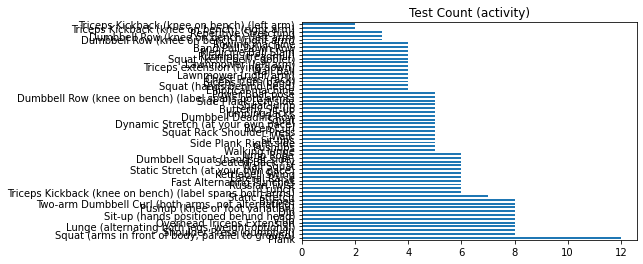

In [ ]:
test_set.activity.value_counts().plot(kind='barh', title='Test Count (activity)')

<AxesSubplot:title={'center':'Train Count (activity)'}>

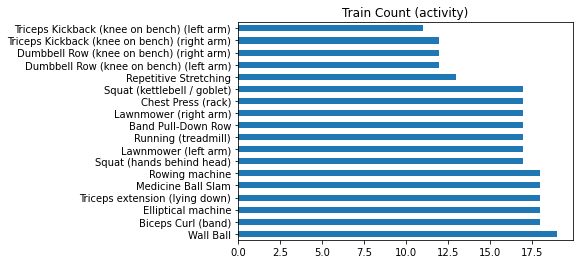

In [ ]:
train_activity_counts = train_set.activity.value_counts()
train_activity_counts[train_activity_counts < 20].plot(kind='barh', title='Train Count (activity)')

<AxesSubplot:title={'center':'Incorrect Count (activity)'}>

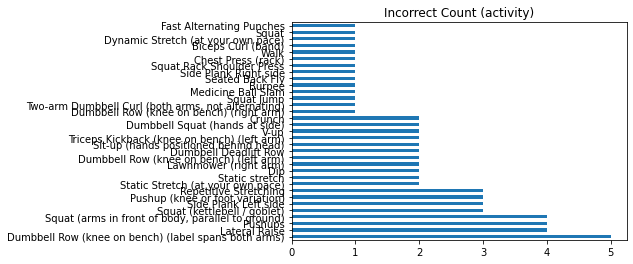

In [ ]:

incorrect_df.activity.value_counts().plot(kind='barh', title='Incorrect Count (activity)')

In [108]:
# cross validate
k = 3
test_loss_values = []
test_accuracies = []
for i in range(3):
    model, train_accuracy, train_average_loss, test_accuracy, test_loss_value = evaluate_model(joined_df)
    print(f"=== Accuracy: {train_accuracy:.4f}, Loss: {train_average_loss:.4f}, Test Accuracy: {test_accuracy:.4f}, Test Loss: {test_loss_value:.4f}")
    test_loss_values.append(test_loss_value)
    test_accuracies.append(test_accuracy)

print(f"Cross-validated test loss: {np.mean(test_loss_values):.4f}, Cross-validated test accuracy: {np.mean(test_accuracies):.4f}")

Epoch [1/200], Accuracy: 0.0253, Loss: 3.4517


Epoch [51/200], Accuracy: 0.5915, Loss: 1.4591
Epoch [101/200], Accuracy: 0.7968, Loss: 0.7985
Epoch [151/200], Accuracy: 0.8837, Loss: 0.5168
Test Accuracy: 0.8489 Test Cross-Entropy Loss: 0.5796
=== Accuracy: 0.9262, Loss: 0.3736, Test Accuracy: 0.8489, Test Loss: 0.5796
Epoch [1/200], Accuracy: 0.0243, Loss: 3.3859
Epoch [51/200], Accuracy: 0.6067, Loss: 1.4662
Epoch [101/200], Accuracy: 0.8049, Loss: 0.8177
Epoch [151/200], Accuracy: 0.8868, Loss: 0.5366
Test Accuracy: 0.8676 Test Cross-Entropy Loss: 0.5638
=== Accuracy: 0.9130, Loss: 0.3962, Test Accuracy: 0.8676, Test Loss: 0.5638
Epoch [1/200], Accuracy: 0.0617, Loss: 3.4121
Epoch [51/200], Accuracy: 0.5743, Loss: 1.4735
Epoch [101/200], Accuracy: 0.7765, Loss: 0.8528
Epoch [151/200], Accuracy: 0.8797, Loss: 0.5729
Test Accuracy: 0.8816 Test Cross-Entropy Loss: 0.5137
=== Accuracy: 0.9039, Loss: 0.4272, Test Accuracy: 0.8816, Test Loss: 0.5137
Cross-validated test loss: 0.5524, Cross-validated test accuracy: 0.8660
